In [2]:
import os
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-27d2043d-b3ee-9f5f-eb43-0020720d54ba)


In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [5]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + n for n in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

 ## Generate train, val, test sets

In [6]:
def preprocess_text_file(filename):
  with open(filename, 'r') as f:
    input_lines = f.readlines()
  abstract_id = ''
  abstract_lines = ''
  abstract_samples = []
  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line.strip()
      abstract_lines = ''

    elif line.isspace():
      abstract_lines_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_lines_split):        
        line_data = {}
        line_splitted = abstract_line.split('\t')
        line_data['abstract_id'] = abstract_id
        line_data['target'] = line_splitted[0]
        line_data['text'] = line_splitted[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_lines_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line
  return abstract_samples

train_samples = preprocess_text_file(data_dir + 'train.txt')
val_samples = preprocess_text_file(data_dir + 'dev.txt')
test_samples = preprocess_text_file(data_dir + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [7]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.shape, val_df.shape, test_df.shape

((180040, 5), (30212, 5), (30135, 5))

In [8]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [9]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## One-hot encode target

In [10]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
train_label_one_hot = onehot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_label_one_hot = onehot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_label_one_hot = onehot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))
train_label_one_hot.shape, val_label_one_hot.shape, test_label_one_hot.shape

((180040, 5), (30212, 5), (30135, 5))

In [11]:
train_label_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode label

In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())
train_labels_encoded.shape, val_labels_encoded.shape, test_labels_encoded.shape

((180040,), (30212,), (30135,))

In [13]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [14]:
num_class = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_class, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Naive Bayes + Tf-idf

In [15]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-29 08:13:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-29 08:13:23 (80.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from helper_functions import calculate_results, create_tensorboard_callback

In [17]:
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()), ('cls', MultinomialNB())
])
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('cls', MultinomialNB())])

In [18]:
y_pred = model_0.predict(val_sentences)
calculate_results(val_labels_encoded, y_pred)

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [22]:
y_pred = model_0.predict(test_sentences)
model0_res = calculate_results(test_labels_encoded, y_pred)
model0_res

{'accuracy': 71.6674962667994,
 'f1': 0.6925101703856846,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994}

## Text to embeddings

In [20]:
from tensorflow.keras.layers import TextVectorization, Embedding

In [21]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
print(np.mean(sent_lens))
max_seq_length = int(np.percentile(sent_lens, 95))
max_seq_length

26.338269273494777


55

In [23]:
max_vocab_size = 68000
text_vectorization = TextVectorization(max_tokens=max_vocab_size, output_sequence_length=max_seq_length)

In [24]:
text_vectorization.adapt(train_sentences)

In [25]:
vocab = text_vectorization.get_vocabulary()
print('Vocab length: {}, top 5: {}, tail 5: {}'.format(len(vocab), vocab[:5], vocab[-5:]))

Vocab length: 64841, top 5: ['', '[UNK]', 'the', 'and', 'of'], tail 5: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [26]:
embedding = Embedding(input_dim=len(vocab), output_dim=256, mask_zero=True, name="embedding_1")

In [27]:
sample = train_sentences[0]
sample, text_vectorization([sample]), embedding(text_vectorization([sample])), embedding(text_vectorization([sample])).shape

('to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 <tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[   6,  331,    2,   79,    4,   53,    4,  161, 1127,  217, 2535,
            5,  557,   65, 1584,    3,  670, 5559,  636,    5,    2,  654,
         1137,    3,  180,    2,   70,  495,   36,  781,   15,   53,    5,
          350,  266,    7,  362,    6,  289,  517, 1430, 1743,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>,
 <tf.Tensor: shape=(1, 55, 256), dtype=float32, numpy=
 array([[[ 0.01334084, -0.0026316 , -0.02881978, ...,  0.04423634,
          -0.02119608,  0.01437471],
         [ 0.02832821,  0.01004624, -0.00454242, ...,  0.04240019,
           0.0326109 ,  0.01014358],
         [ 0.02382073,  

## Create fast loading dataset

In [28]:
train_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_label_one_hot))
val_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_label_one_hot))
test_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_label_one_hot))

train_data = train_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

train_data, val_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Model 1: Conv1D

In [29]:
tb_callback1 = create_tensorboard_callback(dir_name='skimlit_model_logs', experiment_name='model1_conv1D')
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorization(inputs)
x = embedding(x)
x = layers.Conv1D(64, 5, padding='same', activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_class, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1')

Saving TensorBoard log files to: skimlit_model_logs/model1_conv1D/20220629-081418


In [30]:
model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_model1 = model_1.fit(train_data, steps_per_epoch=int(0.1*len(train_data)),
                             epochs=5, validation_data=val_data, callbacks=[tb_callback1])

Epoch 1/5
562/562 [==============================] - 24s 19ms/step - loss: 0.7908 - accuracy: 0.7021 - val_loss: 0.5822 - val_accuracy: 0.7861
Epoch 2/5
562/562 [==============================] - 9s 17ms/step - loss: 0.5702 - accuracy: 0.7911 - val_loss: 0.5366 - val_accuracy: 0.8006
Epoch 3/5
562/562 [==============================] - 9s 17ms/step - loss: 0.5387 - accuracy: 0.8008 - val_loss: 0.5205 - val_accuracy: 0.8054
Epoch 4/5
562/562 [==============================] - 9s 17ms/step - loss: 0.5241 - accuracy: 0.8072 - val_loss: 0.5093 - val_accuracy: 0.8124
Epoch 5/5
562/562 [==============================] - 9s 17ms/step - loss: 0.5291 - accuracy: 0.8091 - val_loss: 0.4946 - val_accuracy: 0.8198


In [31]:
model1_pred_probs = model_1.predict(val_data)
model1_pred = tf.argmax(model1_pred_probs, axis=1)
model1_pred.shape, val_labels_encoded.shape

(TensorShape([30212]), (30212,))

In [32]:
model1_res = calculate_results(val_labels_encoded, model1_pred)
model1_res

{'accuracy': 81.97735998940819,
 'f1': 0.8177217134378413,
 'precision': 0.820600784093795,
 'recall': 0.8197735998940818}

## Model 2: Pretrained USE

In [33]:
import tensorflow_hub as tfhub

In [34]:
tb_callback2 = create_tensorboard_callback(dir_name='nlp_model_logs', experiment_name='model2_USE_pretrained')
sentence_encoder_layer = tfhub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', input_shape=[], dtype=tf.string, trainable=False, name='USE')
inputs = layers.Input(shape=(), dtype=tf.string)
x = sentence_encoder_layer(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(num_class, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2')
model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_model2 = model_2.fit(train_data, steps_per_epoch=int(0.1*len(train_data)),
                             epochs=5, validation_data=val_data, callbacks=[tb_callback2])

Saving TensorBoard log files to: nlp_model_logs/model2_USE_pretrained/20220629-081532
Epoch 1/5
562/562 [==============================] - 19s 27ms/step - loss: 0.9635 - accuracy: 0.6344 - val_loss: 0.8099 - val_accuracy: 0.6905
Epoch 2/5
562/562 [==============================] - 16s 28ms/step - loss: 0.7818 - accuracy: 0.6945 - val_loss: 0.7690 - val_accuracy: 0.7047
Epoch 3/5
562/562 [==============================] - 27s 47ms/step - loss: 0.7687 - accuracy: 0.7058 - val_loss: 0.7584 - val_accuracy: 0.7082
Epoch 4/5
562/562 [==============================] - 15s 26ms/step - loss: 0.7385 - accuracy: 0.7164 - val_loss: 0.7376 - val_accuracy: 0.7192
Epoch 5/5
562/562 [==============================] - 15s 27ms/step - loss: 0.7508 - accuracy: 0.7147 - val_loss: 0.7231 - val_accuracy: 0.7257


In [35]:
model2_pred_probs = model_2.predict(val_data)
model2_pred = tf.argmax(model2_pred_probs, axis=1)
model2_pred.shape, val_labels_encoded.shape

(TensorShape([30212]), (30212,))

In [36]:
model2_res = calculate_results(val_labels_encoded, model2_pred)
model2_res

{'accuracy': 72.57050178736925,
 'f1': 0.7200521970403498,
 'precision': 0.7215448993937543,
 'recall': 0.7257050178736926}

## Model 3: Conv1D with char-level embedding

### Create character level embeddings

In [37]:
def split_chars(text):
  return ' '.join(list(text))

In [38]:
train_chars = [split_chars(sen) for sen in train_sentences]
val_chars = [split_chars(sen) for sen in val_sentences]
test_chars = [split_chars(sen) for sen in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [39]:
char_lens = [len(sen) for sen in train_sentences]
print(np.mean(char_lens))
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

149.3662574983337


290

In [40]:
import string

In [41]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
NUM_CHAR_TOKEN = len(alphabet) + 2
char_vectorization = TextVectorization(max_tokens=NUM_CHAR_TOKEN, output_sequence_length=output_seq_char_len)

In [42]:
char_vectorization.adapt(train_chars)

In [43]:
char_vocab = char_vectorization.get_vocabulary()
print('Char vocab length: {}, top 5: {}, tail 5: {}'.format(len(char_vocab), char_vocab[:5], char_vocab[-5:]))

Char vocab length: 28, top 5: ['', '[UNK]', 'e', 't', 'i'], tail 5: ['k', 'x', 'z', 'q', 'j']


In [44]:
char_embedding = Embedding(input_dim=len(char_vocab), output_dim=25, mask_zero=True,
                           input_length=output_seq_char_len, name='embedding_2')

In [45]:
sample = train_chars[0]
sample, char_vectorization([sample]), char_embedding(char_vectorization([sample])), char_embedding(char_vectorization([sample])).shape

('t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 <tf.Tensor: shape=(1, 290), dtype=int64, numpy=
 array([[ 3,  7,  4,  6, 21,  2,  9,  3,  4, 18,  5,  3,  2,  3, 13,  2,
          2, 17, 17,  4, 11,  5, 11, 19,  7, 17, 20,  2,  2, 23,  9,  7,
         17, 10,  5,  4, 12, 19, 12,  7, 20, 10,  7,  9,  2,  7,  8,  5,
         12, 14,  8,  2, 10,  6,  4,  9,  7, 12,  7,  6,  2,  4,  6,  4,
         15, 14,  8,  7, 21,  4,  6, 18, 14,  5,  4,  6, 15,  7, 22,  4,
         12,  4,  3,

### Fast loading data

In [46]:
train_char_data = tf.data.Dataset.from_tensor_slices((train_chars, train_label_one_hot))
val_char_data = tf.data.Dataset.from_tensor_slices((val_chars, val_label_one_hot))
test_char_data = tf.data.Dataset.from_tensor_slices((test_chars, test_label_one_hot))

train_char_data = train_char_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_char_data = val_char_data.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
test_char_data = test_char_data.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

train_char_data, val_char_data, test_char_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Model

In [47]:
tb_callback3 = create_tensorboard_callback(dir_name='skimlit_model_logs', experiment_name='model3_conv1D_char')
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorization(inputs)
x = char_embedding(x)
x = layers.Conv1D(64, 10, padding='same', activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_class, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3')

Saving TensorBoard log files to: skimlit_model_logs/model3_conv1D_char/20220629-081906


In [48]:
model_3.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_model3 = model_3.fit(train_char_data, steps_per_epoch=int(0.1*len(train_data)),
                             epochs=5, validation_data=val_char_data, callbacks=[tb_callback3])

Epoch 1/5
562/562 [==============================] - 8s 12ms/step - loss: 1.2245 - accuracy: 0.5052 - val_loss: 0.9961 - val_accuracy: 0.6134
Epoch 2/5
562/562 [==============================] - 10s 18ms/step - loss: 0.9475 - accuracy: 0.6282 - val_loss: 0.8946 - val_accuracy: 0.6533
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 0.8618 - accuracy: 0.6686 - val_loss: 0.8157 - val_accuracy: 0.6903
Epoch 4/5
562/562 [==============================] - 6s 10ms/step - loss: 0.8037 - accuracy: 0.6971 - val_loss: 0.7787 - val_accuracy: 0.7053
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7787 - accuracy: 0.7064 - val_loss: 0.7522 - val_accuracy: 0.7158


In [49]:
model3_pred_probs = model_3.predict(val_char_data)
model3_pred = tf.argmax(model3_pred_probs, axis=1)
model3_pred.shape, val_labels_encoded.shape

(TensorShape([30212]), (30212,))

In [50]:
model3_res = calculate_results(val_labels_encoded, model3_pred)
model3_res

{'accuracy': 71.58413875281346,
 'f1': 0.7129076653456893,
 'precision': 0.7173290065837726,
 'recall': 0.7158413875281345}

## Model 4: Combine token and character models

In [51]:
token_input = layers.Input(shape=(), dtype=tf.string)
token_embedding = sentence_encoder_layer(token_input)
token_output = layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(token_input, token_output)

char_input = layers.Input(shape=(1,), dtype=tf.string)
char_vector = char_vectorization(char_input)
char_emb = char_embedding(char_vector)
char_bilstm = layers.Bidirectional(layers.LSTM(24))(char_emb)
char_model = tf.keras.Model(char_input, char_bilstm)

token_char_concat = layers.Concatenate(name='token_char_concat')([token_model.output, char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
last_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_class, activation='softmax')(last_dropout)

model_4 = tf.keras.Model([token_model.input, char_model.input], output_layer, name='model_4')

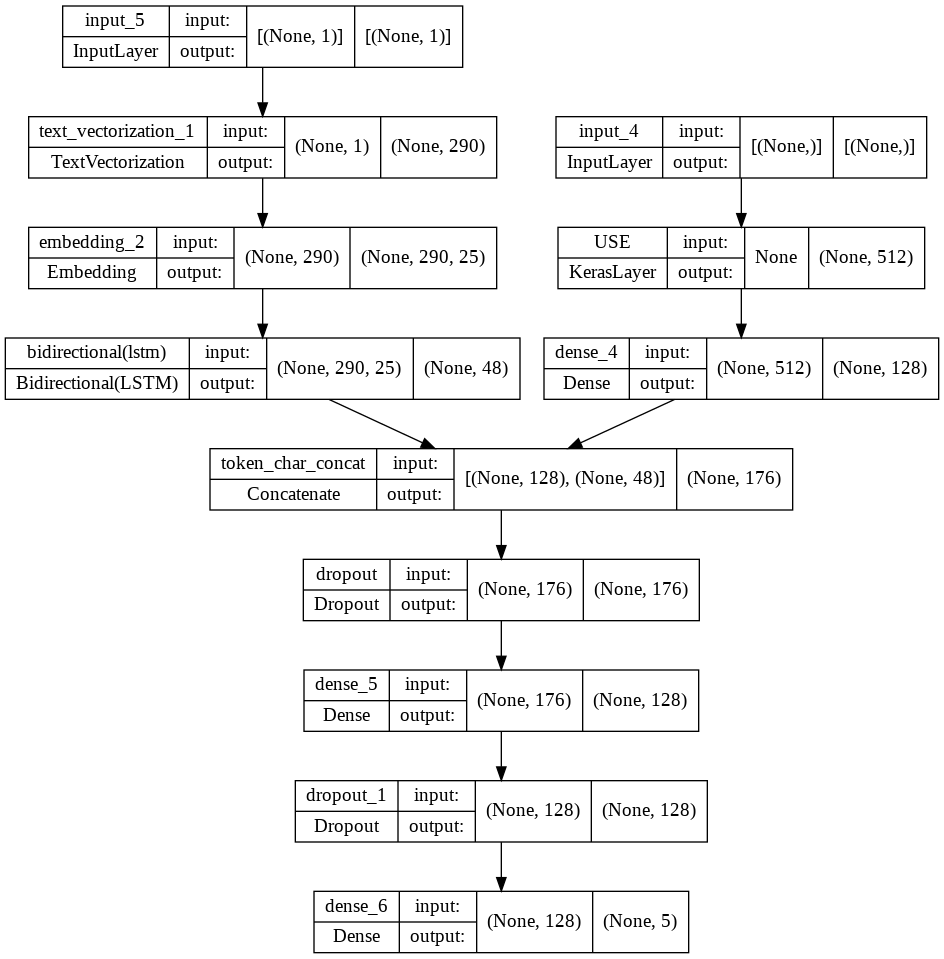

In [52]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

### Fast loading data

In [53]:
train_char_token_inputs = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_label_one_hot)
train_char_token_data = tf.data.Dataset.zip((train_char_token_inputs, train_char_token_labels))

val_char_token_inputs = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_label_one_hot)
val_char_token_data = tf.data.Dataset.zip((val_char_token_inputs, val_char_token_labels))

test_char_token_inputs = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_label_one_hot)
test_char_token_data = tf.data.Dataset.zip((test_char_token_inputs, test_char_token_labels))

train_char_token_data = train_char_token_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_char_token_data = val_char_token_data.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
test_char_token_data = test_char_token_data.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

train_char_token_data, val_char_token_data, test_char_token_data

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fit model

In [54]:
tb_callback4 = create_tensorboard_callback(dir_name='skimlit_model_logs', experiment_name='model4_token_char_combined')
model_4.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_model4 = model_4.fit(train_char_token_data, steps_per_epoch=int(0.1*len(train_char_token_data)),
                             epochs=5, validation_data=val_char_token_data, callbacks=[tb_callback4])


Saving TensorBoard log files to: skimlit_model_logs/model4_token_char_combined/20220629-082134
Epoch 1/5
562/562 [==============================] - 62s 87ms/step - loss: 0.9781 - accuracy: 0.6102 - val_loss: 0.7931 - val_accuracy: 0.6961
Epoch 2/5
562/562 [==============================] - 46s 83ms/step - loss: 0.8021 - accuracy: 0.6896 - val_loss: 0.7199 - val_accuracy: 0.7262
Epoch 3/5
562/562 [==============================] - 45s 80ms/step - loss: 0.7753 - accuracy: 0.7048 - val_loss: 0.6963 - val_accuracy: 0.7350
Epoch 4/5
562/562 [==============================] - 47s 84ms/step - loss: 0.7430 - accuracy: 0.7196 - val_loss: 0.6762 - val_accuracy: 0.7420
Epoch 5/5
562/562 [==============================] - 48s 85ms/step - loss: 0.7490 - accuracy: 0.7144 - val_loss: 0.6598 - val_accuracy: 0.7477


In [55]:
model4_pred_probs = model_4.predict(val_char_token_data)
model4_pred = tf.argmax(model4_pred_probs, axis=1)
model4_pred.shape, val_labels_encoded.shape

(TensorShape([30212]), (30212,))

In [56]:
model4_res = calculate_results(val_labels_encoded, model4_pred)
model4_res

{'accuracy': 74.77492387130941,
 'f1': 0.7437415781444509,
 'precision': 0.743636329611712,
 'recall': 0.7477492387130942}

## Model 5: model_4 with positional embedding

### One hot line_number feature

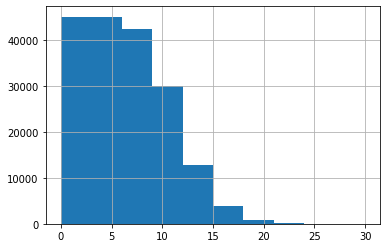

In [57]:
train_df['line_number'].hist()

In [58]:
train_line_number_onehot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_number_onehot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_onehot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_number_onehot.shape, val_line_number_onehot.shape, test_line_number_onehot.shape

(TensorShape([180040, 15]), TensorShape([30212, 15]), TensorShape([30135, 15]))

### One hot total_line feature

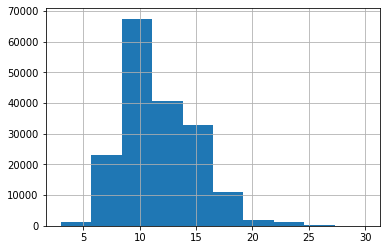

In [59]:
train_df['total_lines'].hist()

In [60]:
train_total_line_onehot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_line_onehot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_line_onehot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_line_onehot.shape, val_total_line_onehot.shape, test_total_line_onehot.shape

(TensorShape([180040, 20]), TensorShape([30212, 20]), TensorShape([30135, 20]))

### Build model

In [61]:
token_input = layers.Input(shape=(), dtype=tf.string, name='token_input')
token_embedding = sentence_encoder_layer(token_input)
token_output = layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(token_input, token_output)

char_input = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vector = char_vectorization(char_input)
char_emb = char_embedding(char_vector)
char_bilstm = layers.Bidirectional(layers.LSTM(24))(char_emb)
char_model = tf.keras.Model(char_input, char_bilstm)

line_number_input = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x1 = layers.Dense(32, activation='relu')(line_number_input)
line_number_model = tf.keras.Model(line_number_input, x1)

total_line_input = layers.Input(shape=(20,), dtype=tf.float32, name='total_line_input')
x2 = layers.Dense(32, activation='relu')(total_line_input)
total_line_model = tf.keras.Model(total_line_input, x2)

# Concat token & char embeddings
token_char_concat = layers.Concatenate(name='token_char_concat')([token_model.output, char_model.output])
x3 = layers.Dense(256, activation='relu')(token_char_concat)
x3 = layers.Dropout(0.5)(x3)

# Concat text & positional embedding
positional_concat = layers.Concatenate(name='positional_concat')([line_number_model.output,
                                                                  total_line_model.output,
                                                                  x3])

output_layer = layers.Dense(num_class, activation='softmax', name='output_layer')(positional_concat)

model_5 = tf.keras.Model([line_number_model.input, total_line_model.input,
                          token_model.input, char_model.input], output_layer, name='model_5')

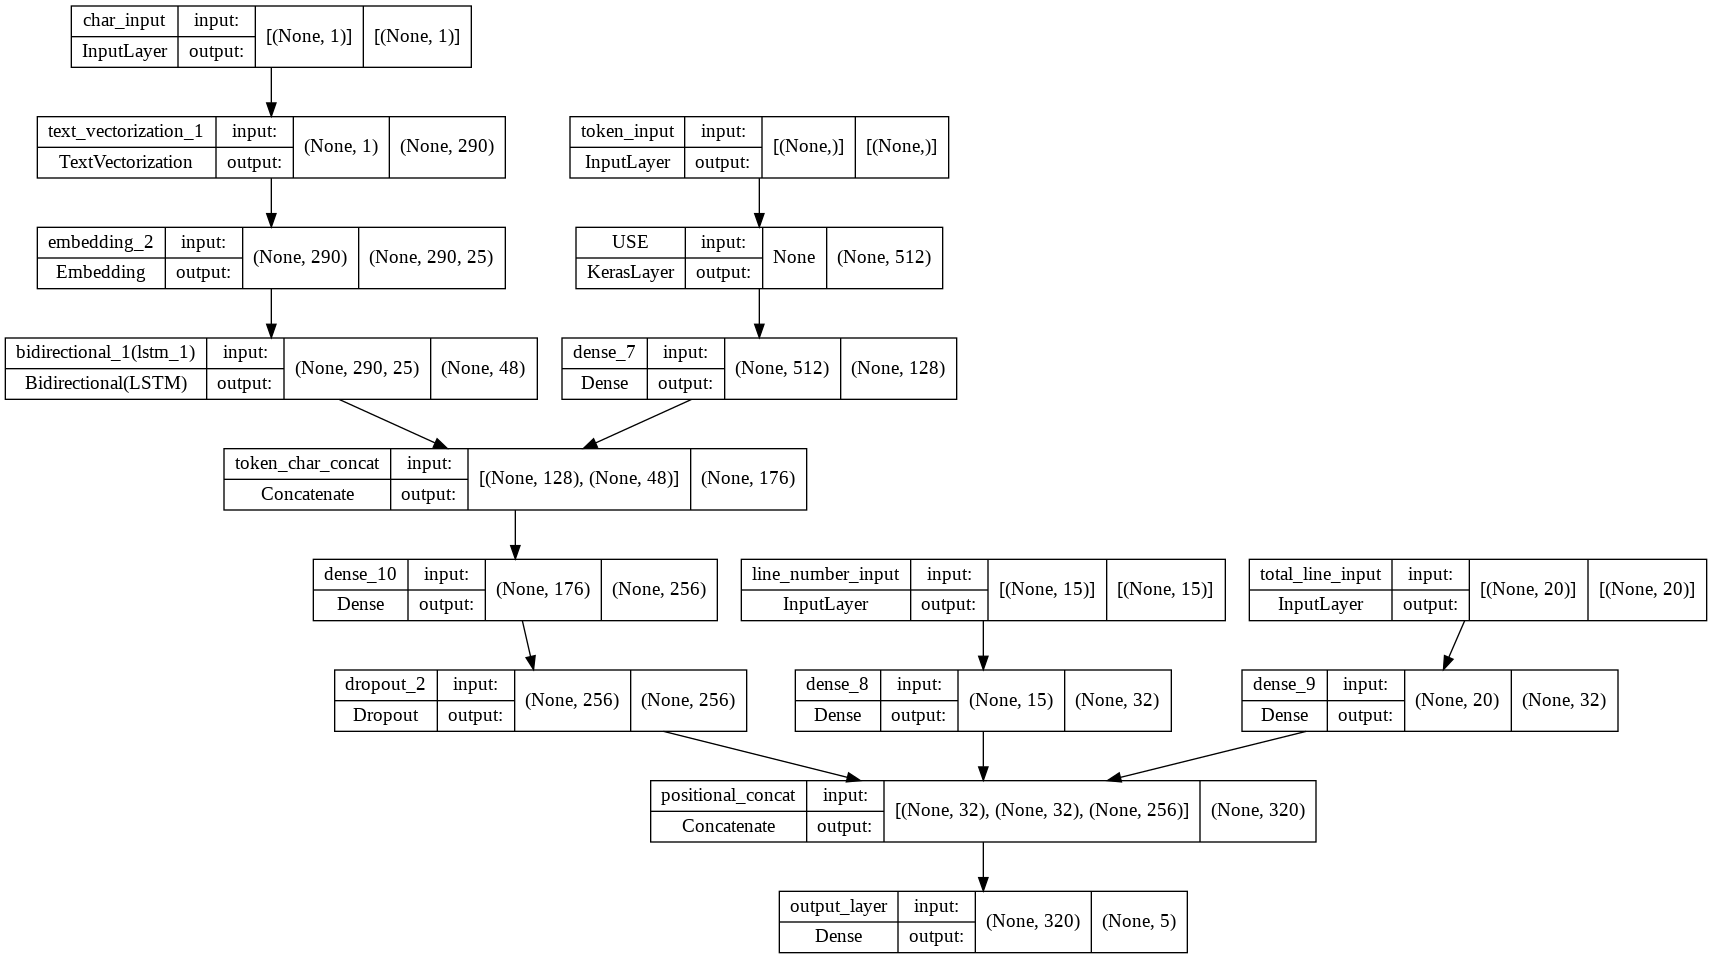

In [62]:
plot_model(model_5, show_shapes=True)

### Fast loading data

In [63]:
train_char_token_pos_inputs = tf.data.Dataset.from_tensor_slices((train_line_number_onehot,
                                                                  train_total_line_onehot,
                                                                  train_sentences, train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_label_one_hot)
train_char_token_pos_data = tf.data.Dataset.zip((train_char_token_pos_inputs, train_char_token_pos_labels))

val_char_token_pos_inputs = tf.data.Dataset.from_tensor_slices((val_line_number_onehot,
                                                            val_total_line_onehot,
                                                            val_sentences, val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_label_one_hot)
val_char_token_pos_data = tf.data.Dataset.zip((val_char_token_pos_inputs, val_char_token_pos_labels))

test_char_token_pos_inputs = tf.data.Dataset.from_tensor_slices((test_line_number_onehot,
                                                                 test_total_line_onehot,
                                                                 test_sentences, test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_label_one_hot)
test_char_token_pos_data = tf.data.Dataset.zip((test_char_token_pos_inputs, test_char_token_pos_labels))

train_char_token_pos_data = train_char_token_pos_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_char_token_pos_data = val_char_token_pos_data.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
test_char_token_pos_data = test_char_token_pos_data.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

train_char_token_pos_data, val_char_token_pos_data, test_char_token_pos_data

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fit model

In [64]:
tb_callback5 = create_tensorboard_callback(dir_name='skimlit_model_logs', experiment_name='model5_token_char_pos_combined')
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_model5 = model_5.fit(train_char_token_pos_data, steps_per_epoch=int(0.1*len(train_char_token_pos_data)),
                             epochs=5, validation_data=val_char_token_pos_data, callbacks=[tb_callback5])

Saving TensorBoard log files to: skimlit_model_logs/model5_token_char_pos_combined/20220629-082704
Epoch 1/5
562/562 [==============================] - 69s 97ms/step - loss: 1.1014 - accuracy: 0.7209 - val_loss: 0.9817 - val_accuracy: 0.8020
Epoch 2/5
562/562 [==============================] - 47s 84ms/step - loss: 0.9665 - accuracy: 0.8141 - val_loss: 0.9483 - val_accuracy: 0.8242
Epoch 3/5
562/562 [==============================] - 44s 79ms/step - loss: 0.9491 - accuracy: 0.8271 - val_loss: 0.9352 - val_accuracy: 0.8364
Epoch 4/5
562/562 [==============================] - 48s 85ms/step - loss: 0.9383 - accuracy: 0.8364 - val_loss: 0.9260 - val_accuracy: 0.8363
Epoch 5/5
562/562 [==============================] - 45s 80ms/step - loss: 0.9355 - accuracy: 0.8369 - val_loss: 0.9214 - val_accuracy: 0.8418


In [65]:
model5_pred_probs = model_5.predict(val_char_token_pos_data)
model5_pred = tf.argmax(model5_pred_probs, axis=1)
model5_pred.shape, val_labels_encoded.shape

(TensorShape([30212]), (30212,))

In [68]:
model5_res = calculate_results(val_labels_encoded, model5_pred)
model5_res

{'accuracy': 84.18178207334834,
 'f1': 0.8380578591454314,
 'precision': 0.8439908413216134,
 'recall': 0.8418178207334834}

In [69]:
all_model_results = pd.DataFrame({"0_baseline": model0_res,
                                  "1_custom_token_embed_conv1d": model1_res,
                                  "2_pretrained_token_embed": model2_res,
                                  "3_custom_char_embed_conv1d": model3_res,
                                  "4_hybrid_char_token_embed": model4_res,
                                  "5_tribrid_pos_char_token_embed": model5_res})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,71.667496,0.712432,0.716675,0.692510
1_custom_token_embed_conv1d,81.977360,0.820601,0.819774,0.817722
2_pretrained_token_embed,72.570502,0.721545,0.725705,0.720052
3_custom_char_embed_conv1d,71.584139,0.717329,0.715841,0.712908
4_hybrid_char_token_embed,74.774924,0.743636,0.747749,0.743742
5_tribrid_pos_char_token_embed,84.181782,0.843991,0.841818,0.838058


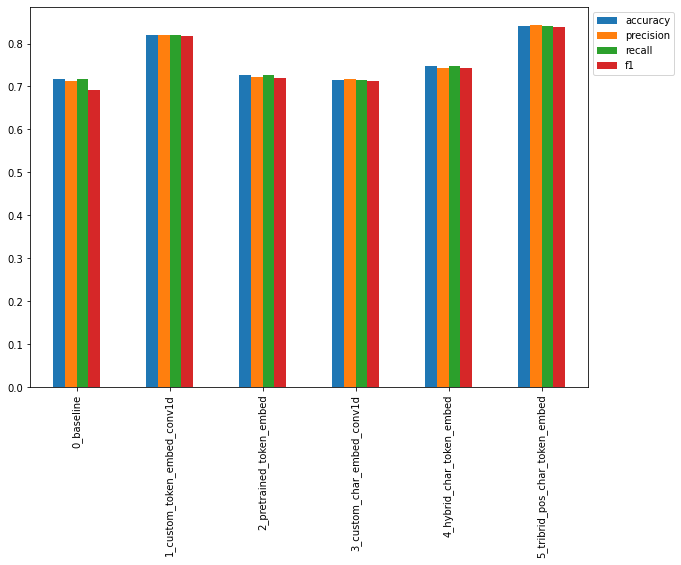

In [70]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

## Save and load model

In [71]:
model_5.save('model5_token_char_pos_combined')

INFO:tensorflow:Assets written to: model5_token_char_pos_combined/assets


INFO:tensorflow:Assets written to: model5_token_char_pos_combined/assets


In [72]:
loaded_model = tf.keras.models.load_model('model5_token_char_pos_combined')

In [73]:
loaded_model_pred_probs = loaded_model.predict(val_char_token_pos_data)
loaded_model_pred = tf.argmax(loaded_model_pred_probs, axis=1)
loaded_model_pred.shape, val_labels_encoded.shape

(TensorShape([30212]), (30212,))

In [74]:
loaded_model_res = calculate_results(val_labels_encoded, loaded_model_pred)
loaded_model_res

{'accuracy': 84.18178207334834,
 'f1': 0.8380578591454314,
 'precision': 0.8439908413216134,
 'recall': 0.8418178207334834}

In [75]:
model5_res

{'accuracy': 84.18178207334834,
 'f1': 0.8380578591454314,
 'precision': 0.8439908413216134,
 'recall': 0.8418178207334834}